## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix,
    accuracy_score,
    plot_roc_curve,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# import xgboost as xgb
# from xgboost import XGBClassifier

pd.set_option('display.max_colwidth', 0)

## Read & Process Data

In [2]:
raw_df = pd.read_csv('raw_dataset.csv')

In [3]:
raw_df = raw_df[raw_df['age'].str.contains(">")==False]

In [4]:
## change to integer

raw_df['age'] = raw_df['age'].astype('int')
raw_df['intubated'] = raw_df['intubated'].astype('Int64')
raw_df['vent'] = raw_df['vent'].astype('Int64')
raw_df['dialysis'] = raw_df['dialysis'].astype('Int64')
raw_df['eyes'] = raw_df['eyes'].astype('Int64')
raw_df['motor'] = raw_df['motor'].astype('Int64')
raw_df['verbal'] = raw_df['verbal'].astype('Int64')
raw_df['ptcawithin24h'] = raw_df['ptcawithin24h'].astype('Int64')

In [6]:
# Drop columns with > 30% null
raw_df.drop(columns=['physicianspeciality',
                    'physicianinterventioncategory',
                    'apacheversion',
                    'predictedhospitalmortality',
                    'predictedicumortality',
                    'predictedhospitallos',
                    'preopmi',
                    'preopcardiaccath',
                    'Unnamed: 0',
                    'predictediculos',
                    'actualicumortality',
                    'unabridgedactualventdays',
                    'actualventdays',
                    'predventdays'], inplace=True)

In [7]:
# Get dummies
one_hot = pd.get_dummies(raw_df[['gender',
                                'ethnicity',
                                'actualhospitalmortality']])

In [8]:
# Final dataset to be used
processed_df = pd.concat([raw_df,one_hot], axis=1)

In [9]:
processed_df.drop(columns=['gender','ethnicity','actualhospitalmortality'],inplace=True)

### Preprocess Data

In [11]:
def fillna_mean(x,df):
    df[x] = df[x].fillna(df[x].mean())
    return df

In [13]:
list_impute_mean=['apachepatientresultsid', 
              'acutephysiologyscore',
             'apachescore',
             'actualiculos',
             'actualhospitallos',
             'admissionheight',
             'admissionweight',
                 'unabridgedunitlos',
                 'unabridgedhosplos']


In [14]:
for i in list_impute_mean:
    fillna_mean(i,processed_df)
    
processed_df

,age,admissionheight,admissionweight,hospitalid,patientunitstayid,intubated,vent,dialysis,eyes,motor,...,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,actualhospitalmortality_ALIVE,actualhospitalmortality_EXPIRED
0,84,180.3,83.749326,73,141894,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,1,0,0,1,0,0,0,0,0
2,73,180.3,122.900000,71,143646,0,0,0,4,6,...,0,1,0,0,1,0,0,0,1,0
3,81,165.1,54.900000,73,144252,0,0,0,4,6,...,0,1,0,0,1,0,0,0,1,0
4,85,157.5,86.300000,73,144944,0,0,0,4,6,...,1,0,0,0,1,0,0,0,1,0
5,64,162.6,83.749326,73,144954,1,1,1,4,6,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,82,170.1,155.000000,458,3351701,0,0,0,4,6,...,0,1,0,0,1,0,0,0,1,0
1773,81,170.0,61.900000,458,3352069,0,0,0,4,6,...,0,1,0,0,1,0,0,0,1,0
1774,41,177.8,127.000000,458,3352231,0,0,0,4,6,...,0,1,1,0,0,0,0,0,1,0
1775,55,180.3,126.000000,458,3352440,0,0,0,4,6,...,0,1,0,0,1,0,0,0,1,0


In [15]:
# Missing value imputation in python using MICE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
IterativeImputer(random_state=42)
imp.fit(processed_df)
processed_array = imp.transform(processed_df)
processed_df = pd.DataFrame(processed_array, columns=list(processed_df.columns))
processed_df.head()

,age,admissionheight,admissionweight,hospitalid,patientunitstayid,intubated,vent,dialysis,eyes,motor,...,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,actualhospitalmortality_ALIVE,actualhospitalmortality_EXPIRED
0,84.0,180.3,83.749326,73.0,141894.0,0.133,0.193165,0.027813,3.661506,5.713507,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,73.0,180.3,122.900000,71.0,143646.0,0.000,0.000000,0.000000,4.000000,6.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,81.0,165.1,54.900000,73.0,144252.0,0.000,0.000000,0.000000,4.000000,6.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,85.0,157.5,86.300000,73.0,144944.0,0.000,0.000000,0.000000,4.000000,6.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,64.0,162.6,83.749326,73.0,144954.0,1.000,1.000000,1.000000,4.000000,6.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Machine Learning Model

In [16]:
X = processed_df.drop(columns=["kidney_problems"])
y = processed_df["kidney_problems"]


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y, 
                                                    random_state=42)

metrics_final = pd.DataFrame(index=[0])

In [17]:
# Baseline score
y_test.value_counts(normalize=True)

0.0    0.887059
1.0    0.112941
Name: kidney_problems, dtype: float64

In [18]:
def get_model(model, gridcv, pipe_params={}):
    
    models = {'lr': LogisticRegression(),
              'nb': MultinomialNB(),
              'rf': RandomForestClassifier(),
              'et': ExtraTreesClassifier(),
              'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
              'knn': KNeighborsClassifier(),
              'gb': GradientBoostingClassifier()}
    
    if model == 'nb':
            pipe = imbpipeline([
                ('sm', SMOTE(random_state=42)), 
                (model, models[model]),
            ])
    else:
            pipe = imbpipeline([
                ('ss', StandardScaler()),
                ('sm', SMOTE(random_state=42)), 
                (model, models[model]),
            ])
    
    pipe_params = pipe_params
    
    gridsearch = GridSearchCV(pipe, pipe_params, cv=gridcv, scoring='roc_auc', verbose=1, n_jobs=-1)
    
    gridsearch.fit(X_train, y_train)
    
    preds = gridsearch.predict(X_test)
    y_train_pred = gridsearch.predict(X_train)
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel() 
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    model_probs_train = gridsearch.predict_proba(X_train)[:, 1]
    model_probs_test = gridsearch.predict_proba(X_test)[:, 1]
    roc_auc = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv=gridcv)
    
    metrics = pd.DataFrame(index=[0])
        
    metrics['model'] = model
    metrics['accuracy'] = accuracy_score(y_test, preds)
    metrics['specificity'] = tn / (tn+fp)
    metrics['recall'] = recall_score(y_test, preds)
    metrics['precision'] = precision_score(y_test, preds)
    metrics['AUC_CV'] = roc_auc.mean()
    metrics['AUC_train'] = roc_auc_score(y_train, model_probs_train)
    metrics['AUC_test'] = roc_auc_score(y_test, model_probs_test)
    metrics['f1_score'] = f1_score(y_test, preds)
    
    metrics['train_accuracy'] = accuracy_score(y_train, y_train_pred)
    metrics['train_specificity'] = tn_train / (tn_train+fp_train)
    metrics['train_recall'] = recall_score(y_train, y_train_pred) 
    metrics['train_precision'] = precision_score(y_train, y_train_pred) 

    print(f'best parameters: {gridsearch.best_params_}')
    print(f'best score: {gridsearch.best_score_}')
        
    return metrics

### Problem statement

Binary classification model between ami-renal patients and ami(non-renal) patients

#### Logistic Regression

In [19]:
%%time

lr_results = get_model('lr', 5, pipe_params={
    'lr__C' : np.logspace(0.01, 1, 10),
    'lr__solver': ['sag','saga', 'liblinear'],    
    'lr__max_iter': [1000, 5000, 10000]
})

lr_results

Fitting 5 folds for each of 90 candidates, totalling 450 fits
best parameters: {'lr__C': 1.318256738556407, 'lr__max_iter': 1000, 'lr__solver': 'liblinear'}
best score: 0.9581335280526615
CPU times: user 1.91 s, sys: 191 ms, total: 2.1 s
Wall time: 1min 41s


,model,accuracy,specificity,recall,precision,AUC_CV,AUC_train,AUC_test,f1_score,train_accuracy,train_specificity,train_recall,train_precision
0,lr,0.896471,0.888594,0.958333,0.522727,0.957978,0.970803,0.950928,0.676471,0.909733,0.90177,0.972222,0.557769


In [20]:
%%time

rf_results = get_model('rf', 5, pipe_params={
    'rf__n_estimators': [100, 125, 150],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [2, 5, 10, 20]
})

rf_results
                        

Fitting 5 folds for each of 36 candidates, totalling 180 fits
best parameters: {'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
best score: 0.9654540302541523
CPU times: user 4.38 s, sys: 96.3 ms, total: 4.47 s
Wall time: 59 s


,model,accuracy,specificity,recall,precision,AUC_CV,AUC_train,AUC_test,f1_score,train_accuracy,train_specificity,train_recall,train_precision
0,rf,0.905882,0.901857,0.9375,0.54878,0.962297,0.994832,0.946342,0.692308,0.932496,0.924779,0.993056,0.627193


In [21]:
%%time

knn_results = get_model('knn', 5, pipe_params={
    'knn__leaf_size': [10, 20, 30],
    'knn__n_neighbors': [10, 25, 50, 75],
    'knn__p': [1, 2]
})

knn_results

Fitting 5 folds for each of 24 candidates, totalling 120 fits
best parameters: {'knn__leaf_size': 10, 'knn__n_neighbors': 75, 'knn__p': 1}
best score: 0.9430707528662975
CPU times: user 1.09 s, sys: 63.5 ms, total: 1.15 s
Wall time: 2.4 s


,model,accuracy,specificity,recall,precision,AUC_CV,AUC_train,AUC_test,f1_score,train_accuracy,train_specificity,train_recall,train_precision
0,knn,0.865882,0.856764,0.9375,0.454545,0.90085,0.958309,0.934295,0.612245,0.868132,0.853982,0.979167,0.460784


In [22]:
%%time

gb_results = get_model('gb', 5, pipe_params={
    'gb__max_depth': [3,5],
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [.05, .1, .15],
    'gb__min_samples_leaf':[10,15],
    'gb__min_samples_split':[10, 15],
})

gb_results

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best parameters: {'gb__learning_rate': 0.05, 'gb__max_depth': 5, 'gb__min_samples_leaf': 15, 'gb__min_samples_split': 10, 'gb__n_estimators': 100}
best score: 0.9646061292994463
CPU times: user 6.99 s, sys: 163 ms, total: 7.15 s
Wall time: 3min 54s


,model,accuracy,specificity,recall,precision,AUC_CV,AUC_train,AUC_test,f1_score,train_accuracy,train_specificity,train_recall,train_precision
0,gb,0.92,0.928382,0.854167,0.602941,0.96046,0.996147,0.945126,0.706897,0.963108,0.959292,0.993056,0.756614


In [23]:
%%time

ada_results = get_model('ada', 5, pipe_params={
    'sm__k_neighbors': [20, 50, 80], 
    'ada__n_estimators': [30, 50, 80],
    'ada__learning_rate': [0.1, 0.3, 0.7, 1],
    'ada__base_estimator__max_depth': [1, 2] 
})

ada_results

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best parameters: {'ada__base_estimator__max_depth': 2, 'ada__learning_rate': 0.1, 'ada__n_estimators': 50, 'sm__k_neighbors': 20}
best score: 0.963392039757618
CPU times: user 2.32 s, sys: 119 ms, total: 2.44 s
Wall time: 1min 32s


,model,accuracy,specificity,recall,precision,AUC_CV,AUC_train,AUC_test,f1_score,train_accuracy,train_specificity,train_recall,train_precision
0,ada,0.915294,0.925729,0.833333,0.588235,0.790182,0.988084,0.948082,0.689655,0.940345,0.934513,0.986111,0.657407


In [24]:
overall_df = pd.concat([lr_results, rf_results, knn_results, gb_results, ada_results], axis=0)

In [25]:
overall_df

,model,accuracy,specificity,recall,precision,AUC_CV,AUC_train,AUC_test,f1_score,train_accuracy,train_specificity,train_recall,train_precision
0,lr,0.896471,0.888594,0.958333,0.522727,0.957978,0.970803,0.950928,0.676471,0.909733,0.901770,0.972222,0.557769
0,rf,0.905882,0.901857,0.937500,0.548780,0.962297,0.994832,0.946342,0.692308,0.932496,0.924779,0.993056,0.627193
0,knn,0.865882,0.856764,0.937500,0.454545,0.900850,0.958309,0.934295,0.612245,0.868132,0.853982,0.979167,0.460784
0,gb,0.920000,0.928382,0.854167,0.602941,0.960460,0.996147,0.945126,0.706897,0.963108,0.959292,0.993056,0.756614
0,ada,0.915294,0.925729,0.833333,0.588235,0.790182,0.988084,0.948082,0.689655,0.940345,0.934513,0.986111,0.657407


In [26]:
ss = StandardScaler()
Xsc_train = ss.fit_transform(X_train)
Xsc_test = ss.transform(X_test)

pipe = imbpipeline([
                ('sm', SMOTE(random_state=42)), 
                ('gb', GradientBoostingClassifier()),
            ])

# best parameters: {'gb__learning_rate': 0.1, 
# 'gb__max_depth': 5, 'gb__min_samples_leaf': 10, 
#         'gb__min_samples_split': 15, 'gb__n_estimators': 150}

pipe_params = {
    'gb__learning_rate': [0.1], 
    'gb__max_depth': [5], 
    'gb__min_samples_leaf': [10], 
     'gb__min_samples_split': [15], 
     'gb__n_estimators': [150]
}
    
#GriSesarchCV on user assigned parameters
gb_gridsearch = GridSearchCV(pipe, pipe_params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    
gb_gridsearch.fit(Xsc_train, y_train)

gb_preds = gb_gridsearch.predict(Xsc_test)
tn, fp, fn, tp = confusion_matrix(y_test, gb_preds).ravel()

gb_model_probs_train = gb_gridsearch.predict_proba(Xsc_train)[:, 1]
gb_model_probs_test = gb_gridsearch.predict_proba(Xsc_test)[:, 1]
gb_roc_auc = cross_val_score(pipe, Xsc_train, y_train, scoring='roc_auc', cv=5)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


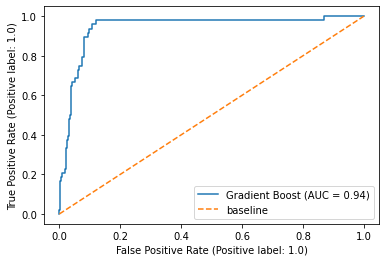

In [27]:
plot_roc_curve(gb_gridsearch, Xsc_test, y_test, name='Gradient Boost')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

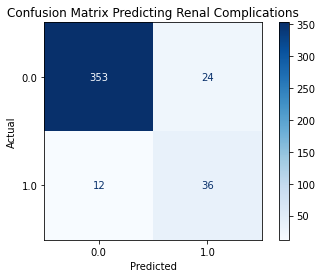

In [28]:
plot_confusion_matrix(gb_gridsearch, Xsc_test, y_test,cmap='Blues', 
                      values_format='d')
plt.title("Confusion Matrix Predicting Renal Complications")
plt.xlabel('Predicted')
plt.ylabel('Actual');

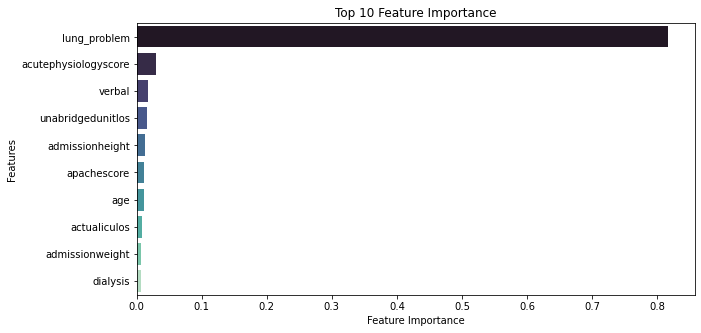

In [29]:
## Plot top 10 feature importance
feature_importance = pd.DataFrame(gb_gridsearch.best_estimator_.steps[1][1].feature_importances_, index = X_train.columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

top_10 = feature_importance.head(10)
plt.figure(figsize=(10,5))
sns.barplot(y=top_10.index,x="Feature Importance", data=top_10, palette = 'mako')
plt.title('Top 10 Feature Importance')
plt.ylabel('Features');